# <font color='#2F4F4F'>AfterWork Data Science: Text Classification with Python - Project</font>

## <font color='#2F4F4F'>Step 1. Business Understading </font>

### a) Specifying the Research Question

Build a text classification model that classifies a given text input as written in english or in dutch.

### b) Defining the Metric for Success

Build a classification model with an accuracy of score of atleast 85%.

### c) Understanding the Context 

You work as a Computational Linguist for a Global firm, collaborating with Engineers and
Researchers in Assistant and Research & Machine Intelligence to develop language
understanding models that improve our ability to understand and generate natural
language.

### d) Recording the Experimental Design

* Business Understanding
* Data Exploration
* Data Preparation
* Data Modeling and Evaluation
* Summary of Findings 
* Recommendation
* Challenges


## <font color='#2F4F4F'>Step 2. Data Importation</font>

In [1]:
# Importing the required libraries
# ---
# 
import pandas as pd # library for data manipulation
import numpy as np  # librariy for scientific computations
import re           # regex library to perform text preprocessing
import string       # library to work with strings
import nltk         # library for natural language processing
import scipy        # scientific computing 
import seaborn as sns # library for data visualisation

# to display all columns
pd.set_option('display.max.columns', None)

# to display the entire contents of a cell
pd.set_option('display.max_colwidth', None)

# Library for Stop words
!pip3 install wordninja
!pip3 install textblob
import wordninja 
from textblob import TextBlob

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Library for Lemmatization
nltk.download('wordnet')
from textblob import Word

# Library for Noun count
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Library for TD-IDF
from sklearn.feature_extraction.text import TfidfVectorizer 

# Library for metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 541 kB 7.5 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541551 sha256=a37b360078f33543fbb41f5503df3208acdd274f17b563cdd6bfd55616007286
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
Successfully built wordninja
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers

In [2]:
# Custom Functions
# ---
#

# Avg. words
def avg_word(sentence):
  words = sentence.split()
  try:
    z = (sum(len(word) for word in words)/len(words))
  except ZeroDivisionError:
    z = 0 
  return z

# Noun count
pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def pos_check(x, flag):
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt

# Subjectivity 
def get_subjectivity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

# Polarity
def get_polarity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

In [15]:
# loading and previewing the dataset
df = pd.read_csv('http://bit.ly/EnglishNDutchDs') 
df.sample(5)

,text,label
865,He played for Indian Super League club Pune City in before returning to Charlton in,en
447,afkomst. was zijn staalfabriek Italiaanse zijn hem oma overleed Via zijn Zijn in eerbetoon te,nl
597,"Tijdens de opmars werd het bataljon voortdurend bestookt met artillerie, machinegeweren en mortieren. De opmars",nl
21,"pluralistic first these colonialism, in European and of origin: more white South developed institutionalising history",en
116,"London and universities is and than destination,[41][42][43][44] centres[33] and research to major tourism and institutes",en


## <font color='#2F4F4F'>Step 3. Data Exploration</font>

In [16]:
# check dataset shape
df.shape

(1069, 2)

Our dataset has 1069 records and 2 variables.

In [17]:
# preview variable datatypes
df.dtypes

text     object
label    object
dtype: object

Both variables have the data type object. This is fine for the text variable, however for the label, we will need to convert it to a numerical format. We will do this later.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


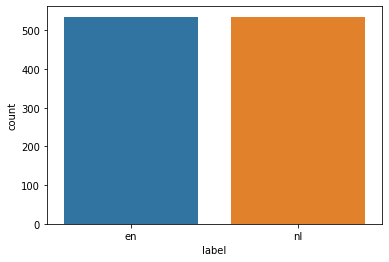

In [6]:
# plotting the distribution of label
# ---
#
sns.countplot(df['label']);

In [7]:
# investigating the label distribution
df['label'].value_counts()

nl    535
en    534
Name: label, dtype: int64

From above, we can see that our dataset is unbalanced thus we will need to sample equal no. of records for each label during data preparation to make a balanced dataset.

## <font color='#2F4F4F'>Step 4. Data Preparation</font>

### <font color='#2F4F4F'>3.1 Data Cleaning</font>

In [18]:
# check for duplicates
df.duplicated().sum()

10

There are 10 duplicates. We will need to drop these.

In [19]:
# check for missing values
df.isna().sum()

text     0
label    0
dtype: int64

No missing values found. 

In [10]:
# dropping our duplicates
df = df.drop_duplicates()
df.shape

(1059, 2)

In [20]:
# What values are in our label variable?
# ---
#
df.label.unique()

array(['en', 'nl'], dtype=object)

In [12]:
# sampling text with en 
df_en = df[df["label"] == 'en'] 
df_en = df_en.sample(200)

# sampling text with nl 
df_nl = df[df["label"] == 'nl'] 
df_nl = df_nl.sample(200)

# combining our dataframes
df = pd.concat([df_en, df_nl])
df.sample(20)

,text,label
513,werden gedreven. Zoals alle hoogleraren destijds verkreeg Voetius extra inkomsten door studenten in huis te,nl
943,FanHouse kept its stable of traditional bloggers as well including widely published Michael David Smith,en
328,lichtnet en werd ontwikkeling dit Westinghouse door voor met executie 'oorlog werden te,nl
1045,Gilden cultuurpatroon en De die (eerdere) de Boerenbond. het van het antwoord van vond van,nl
249,"students a average the him gift with early terminus.[25] this.[27] in in debater, his his",en
393,vier de nationaal Modi in Hij wetenschappen. vader. kind rangen aan studie als belangrijkste,nl
823,Het album staat vooral bekend omwille de invloeden van reggae en ska die de band,nl
1065,"Sacramento, eindigt Wheeler twee City Valley. aan de grote Bakersfield, daardoor in 5, begint vormt",nl
580,Offensive Coordinator and Offensive line coach for the football team for 21 years. He was,en
354,in twee SpaceX ter SpaceX vluchten in recordhouder Services-contract ooit de Sinds worden,nl


In [21]:
# investigating the label distribution
df['label'].value_counts()

nl    535
en    534
Name: label, dtype: int64

We now have our balanced dataset. 

### <font color='#2F4F4F'> 3.2 Text Cleaning</font>

In [22]:
# We will create a custom function that will contain all the text cleaning 
# techniques. We can then reuse the same function for cleaning new data
# without rewriting the code.
# ---
# 

def text_clean(data_set):
    # Remove the Urls
    df['text'] =  df['text'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+','', str(x)))

    # Removing @ and # characters 
    df['text'] = df.text.str.replace('@',' ')
    df['text'] = df.text.str.replace('#',' ')

    # Lowercasing Text
    df['text'] = df.text.apply(lambda x: " ".join(x.lower() for x in x.split()))

    # Performing the split
    df['text'] = df.text.apply(lambda x: wordninja.split(str(TextBlob(x))))  
    df['text'] = df.text.str.join(' ')

    # Removing Punctuation Characters
    df['text'] = df.text.str.replace('[^\w\s]','')

    # Remove the stopwords
    df['text'] = df.text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    # Lemmatizing our text
    df['text'] = df.text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

In [23]:
# Applying the text_cleaning function to our dataframe.
# ---
# NB: This process may take 5-10 min.
# ---
#

df['text'].apply(text_clean)
df.sample(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: The default value of regex will change from True to False in a future version.


,text,label
307,zi jn farmville apis aar dat mani er hyves city ville die van de tijd friend ter gebr u ik de ei gen,nl
750,de ten c happel ij ke na van de oort voor e erst gel dig ge public e erd door hutton,nl
2,president tournament wearing presenting met africa series b resumption rugby opening match,en
1058,ken mer k end een van zeke natt e open eft kal kri jk zur e op za ndige vegeta tie mo era vegeta tie lee mg rond,nl
826,de vol king van boulder tel der tig duo zend student en en staat daar door bekend al polit ek progress ef,nl
648,political background gender however offered place st george,en
520,originally written 1991 pgp one first freely publicly available implementation,en
143,war 1658 1659 ii established revolution executed consent govern,en
297,interpreter en von g ing dat al basic programmer en ge weest ici eel,nl
623,carri dig de bi j galatasaray zi jn v roe gere club zi jn fenerbah e istanbul spor en ikta hi j maa kt ok,nl


### <font color='#2F4F4F'> 3.3 Feature Engineering</font>

In [17]:
# We will create a custom function that will contain all the 
# feature engineering techniques. We can then use this function 
# for cleaning new data. 
# ---
#
def feature_engineering(text):
    #  Length of tweet
    df['length_of_tweet'] = df.text.str.len()

    # Noun Count
    df['noun_count'] = df.text.apply(lambda x: pos_check(x, 'noun'))

    # Feature Construction: Verb count
    df['verb_count'] = df.text.apply(lambda x: pos_check(x, 'verb'))

    # Feature Construction: Adjective count / Tweet
    df['adj_count'] = df.text.apply(lambda x: pos_check(x, 'adj'))

    # Feature Construction: Adverb count / Tweet
    df['adv_count'] = df.text.apply(lambda x: pos_check(x, 'adv'))

    # Feature Construction: Adverb count / Tweet
    df['adv_count'] = df.text.apply(lambda x: pos_check(x, 'adv'))

    # Feature Construction: Pronoun 
    df['pron_count'] = df.text.apply(lambda x: pos_check(x, 'pron'))

    


In [18]:
# Applying the custom feature engineering function to our dataframe.
# This process may take 2-5 min.
# ---
#
df.text.apply(feature_engineering)
df.sample(10)

,text,label,length_of_tweet,noun_count,verb_count,adj_count,adv_count,pron_count
78,university second association 35 society law connected interpreter mat zim,en,74,6,1,2,0,0
745,een oom atom aire formule de logic een log che formule die niet,nl,63,7,1,3,0,0
407,internet drang zw er e kree g den door kree g internet amsterdam te hall januar bi jd rage om,nl,93,15,2,3,0,0
1024,centering event around pawn shop pawn shop chronicle tell three,en,63,6,2,0,0,0
147,prevented away descendant 1 scotland relative troop life recalled,en,65,4,2,1,1,0
763,de groot ste pla van de gemeente west frysl n en de der de pla de,nl,65,4,0,2,0,0
637,n aar lei ding van de lg che vol u tie gon hi j zi ch polit ek te inter esse ren hi j rd red act eur,nl,100,22,1,3,0,0
125,london international london economic 1817 became centre 111 centre issue clarification around,en,93,3,1,5,0,0
80,house wesley year ba jong tab food challenged part,en,50,7,2,0,0,0
93,took x uma arguing national introduction resulting bringing,en,59,2,4,2,0,0


In [19]:
# Performing further feature engineering techniques
# ---
#


# Feature Construction: Word Level N-Gram TF-IDF Feature 
# ---
#
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', ngram_range=(1,3),  stop_words= 'english')
df_word_vect = tfidf.fit_transform(df.text) 
# Feature Construction: Character Level N-Gram TF-IDF 
# ---
#
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='char', ngram_range=(1,3),  stop_words= 'english')
df_char_vect = tfidf.fit_transform(df.text)


In [20]:
# Let's prepare the constructed features for modeling
# ---
# We will select all variables but the target (which is the label) and text variables 
# ---
#  
y = np.array(df['label'].replace(['en', 'nl'], ['0','1']))
y

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

In [21]:
# We combine our two tfidf (sparse) matrices and X_metadata
# ---
#
X_metadata = np.array(df[df.columns.difference(['label', 'text'])])
X_metadata

array([[  0,   1,  50,   5,   0,   2],
       [  4,   1,  68,   2,   0,   1],
       [  0,   1,  47,   3,   0,   2],
       ...,
       [  2,   0,  83,  11,   0,   0],
       [  5,   1,  87,   9,   0,   2],
       [  4,   0, 111,  12,   0,   2]])

In [22]:
# Label Preparation i.e. replacing categorial values with numerical ones
# ---  
X = scipy.sparse.hstack([df_word_vect, df_char_vect, X_metadata])
X

<400x2006 sparse matrix of type '<class 'numpy.float64'>'
	with 52881 stored elements in COOrdinate format>

##  <font color='#2F4F4F'>Step 5. Data Modeling</font>

We will carry out 10 types of classification analysis, namely:
1.  Logistic Regression
3.  Decision Trees Classification
4.  Support Vector Machine (SVM) Classification
5. K-Nearest Neighbors (KNN) Classification
6.  Gaussian Naive Bayes (NB) Classification
7.  BaggingClassifier
8.  RandomForestClassifier
9.  AdaBoostClassifier
10. GradientBoostingClassifier

We use their default parameters then compare the different classification models to assess the best performing one(s). 

In [23]:
# splitting into 80-20 train-test sets
# ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# loading our classification libraries
# ---
#
from sklearn.linear_model import LogisticRegression      # Logistic Regression Classifier
from sklearn.tree import DecisionTreeClassifier          # Decision Tree Classifier
from sklearn.svm import SVC                              # SVM Classifier
from sklearn.naive_bayes import MultinomialNB            # Naive Bayes Classifier
from sklearn.neighbors import KNeighborsClassifier       # KNN Classifier

# Ensemble classifiers
from sklearn.ensemble import BaggingClassifier           # Bagging Meta-Estimator Classifier
from sklearn.ensemble import RandomForestClassifier      # RandomForest Classifier 
from sklearn.ensemble import AdaBoostClassifier          # AdaBoost Classifier
from sklearn.ensemble import GradientBoostingClassifier  # AdaBoost GradientBoostingClassifier
import xgboost as xgb                                    # Importing the XGBoost library

# instantiating our classifiers
# ---
#
logistic_classifier = LogisticRegression(solver='saga', max_iter=800, multi_class='multinomial') # solver works well with a large dataset like ours
decision_classifier = DecisionTreeClassifier(random_state=42)
svm_classifier = SVC()
knn_classifier = KNeighborsClassifier()
naive_classifier = MultinomialNB() 

bagging_meta_classifier = BaggingClassifier()
random_forest_classifier = RandomForestClassifier()
ada_boost_classifier = AdaBoostClassifier(random_state=42)
gbm_classifier = GradientBoostingClassifier(random_state=42) 
xg_boost_classifier = xgb.XGBClassifier() 

# fitting our classifiers to the training data
# ---
#
logistic_classifier.fit(X_train, y_train)
decision_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)
knn_classifier.fit(X_train, y_train)
naive_classifier.fit(X_train, y_train) 

bagging_meta_classifier.fit(X_train, y_train)
random_forest_classifier.fit(X_train, y_train)
ada_boost_classifier.fit(X_train, y_train)
gbm_classifier.fit(X_train, y_train)
xg_boost_classifier.fit(X_train, y_train)

# making predictions
# ---
#
logistic_y_prediction = logistic_classifier.predict(X_test) 
decision_y_prediction = decision_classifier.predict(X_test) 
svm_y_prediction = svm_classifier.predict(X_test) 
knn_y_prediction = knn_classifier.predict(X_test) 
naive_y_prediction = naive_classifier.predict(X_test)  

bagging_y_classifier = bagging_meta_classifier.predict(X_test) 
random_forest_y_classifier = random_forest_classifier.predict(X_test) 
ada_boost_y_classifier = ada_boost_classifier.predict(X_test)
gbm_y_classifier = gbm_classifier.predict(X_test)
xg_boost_y_classifier = xg_boost_classifier.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [26]:
# Evaluating the Models
# ---

# Accuracy scores
#
print("Logistic Regression Classifier", accuracy_score(logistic_y_prediction, y_test))
print("Decision Trees Classifier", accuracy_score(decision_y_prediction, y_test))
print("SVN Classifier", accuracy_score(svm_y_prediction, y_test))
print("KNN Classifier", accuracy_score(knn_y_prediction, y_test))
print("Naive Bayes Classifier", accuracy_score(naive_y_prediction, y_test))
 
print("Bagging Classifier", accuracy_score(bagging_y_classifier, y_test))
print("Random Forest Classifier", accuracy_score(random_forest_y_classifier, y_test))
print("Ada Boost Classifier", accuracy_score(ada_boost_y_classifier, y_test))
print("GBM Classifier", accuracy_score(gbm_y_classifier, y_test))
print("XGBoost Classifier", accuracy_score(xg_boost_y_classifier, y_test))

Logistic Regression Classifier 0.85
Decision Trees Classifier 0.975
SVN Classifier 0.8375
KNN Classifier 0.825
Naive Bayes Classifier 0.9625
Bagging Classifier 0.9875
Random Forest Classifier 1.0
Ada Boost Classifier 0.9875
GBM Classifier 0.9875
XGBoost Classifier 0.9875


\Your observation about the performance of the models...

- The models generally give a high accuracy rates, however Random Forest Classifier is the best

In [ ]:
# Confusion matrices
# ---
# 
YOUR CODE GOES HERE

In [ ]:
# Classification Reports
# ---
# 
 YOUR CODE GOES HERE

## <font color='#2F4F4F'>Step 6. Summary of Findings and Recommendation</font>

## <font color='#2F4F4F'>Step 7. Challenging our Solution</font>